# Identifying Hate Speech Patterns in Social Media Platforms

### 1. Importing the reqiured libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.util import pr
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

### 2. Read Data From the CSV File

In [4]:
data = pd.read_csv('labeled_data.csv')
# pd.set_option('display.max_colwidth',None)
data.head()

,INDEX,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### 3. Information About Data

* *Size of the Data:*

In [5]:
data.size

173481

* *Shape of the Data:*

In [6]:
data.shape

(24783, 7)

* *Colums of the Data:*

In [7]:
data.columns

Index(['INDEX', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

* *Information of data:*

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   INDEX               24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


* *Finding the Null Data:*

In [9]:
data.isnull().sum()

INDEX                 0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

### 3. Graphical Representation of Data:

#### 3.1. Class:

* *Class label for majority CrowdFlower of users.*

* * *0 - hate speech*

* * *1 - offensive language*

* * *2 - neither*

In [10]:
data['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

<Axes: title={'center': 'Class Histogram'}, ylabel='Frequency'>

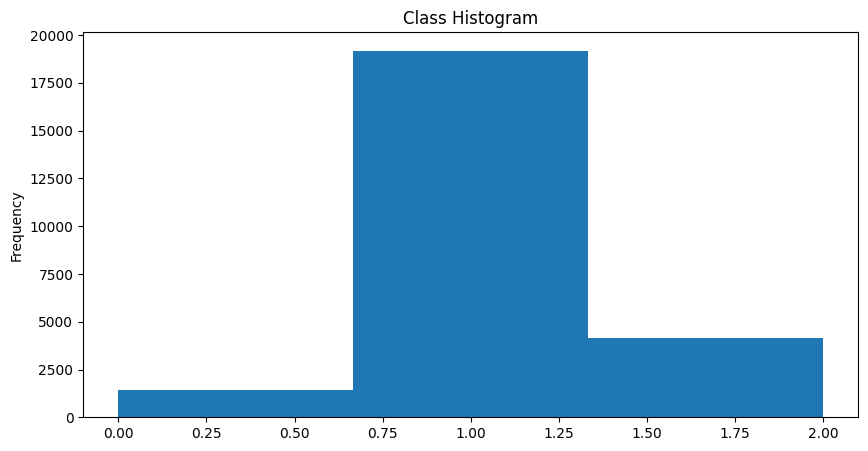

In [11]:
data['class'].plot.hist(title='Class Histogram', bins=3, figsize=(10,5))

#### 3.2. Count:

* *Number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)*

In [12]:
data['count'].value_counts()

count
3    22807
6     1571
4      211
9      167
7       27
Name: count, dtype: int64

<Axes: title={'center': 'Count Histogram'}, ylabel='Frequency'>

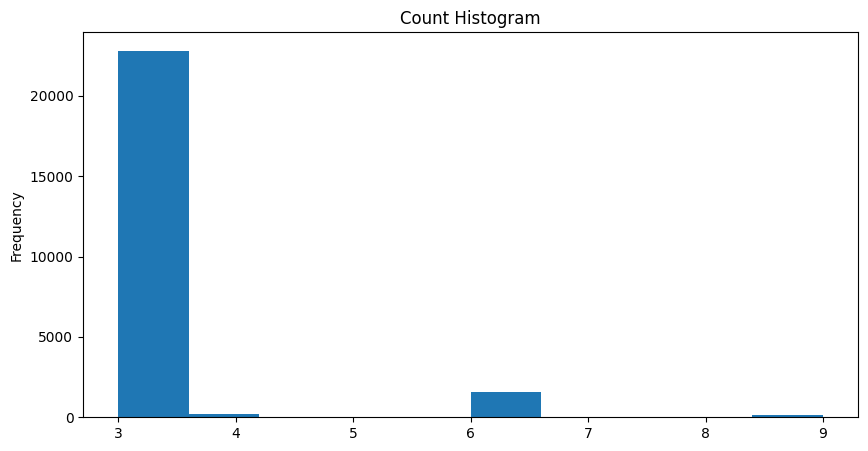

In [13]:
data['count'].plot.hist(title='Count Histogram',bins=10,figsize=(10,5))

#### 3.3. Hate Speech:

* *Number of CrowdFlower users who judged the tweet to be hate speech.*

In [14]:
data['hate_speech'].value_counts()

hate_speech
0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: count, dtype: int64

<Axes: title={'center': 'Hate Speech Histogram'}, ylabel='Frequency'>

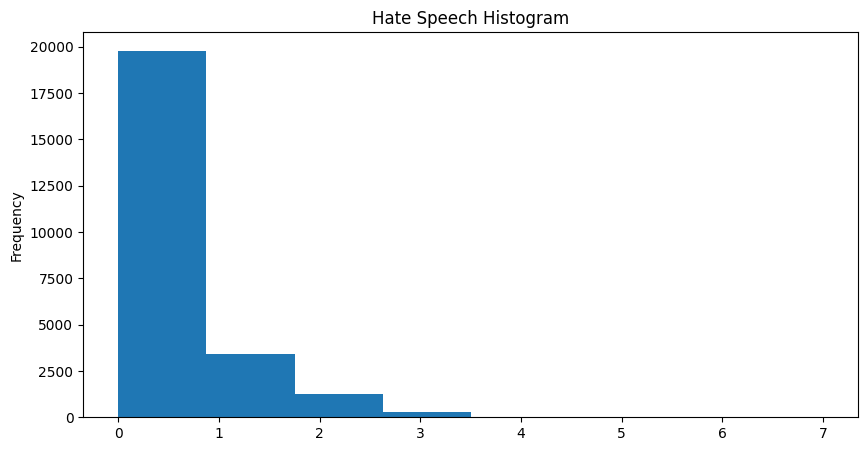

In [15]:
data['hate_speech'].plot.hist(title='Hate Speech Histogram', bins=8, figsize=(10,5))

#### 3.4. Offensive Language:

* *Number of CrowdFlower users who judged the tweet to be offensive.*

In [16]:
data['offensive_language'].value_counts()

offensive_language
3    13383
2     4246
0     3475
1     2066
6      857
5      369
4      251
9       66
8       37
7       33
Name: count, dtype: int64

<Axes: title={'center': 'Offensive Language Histogram'}, ylabel='Frequency'>

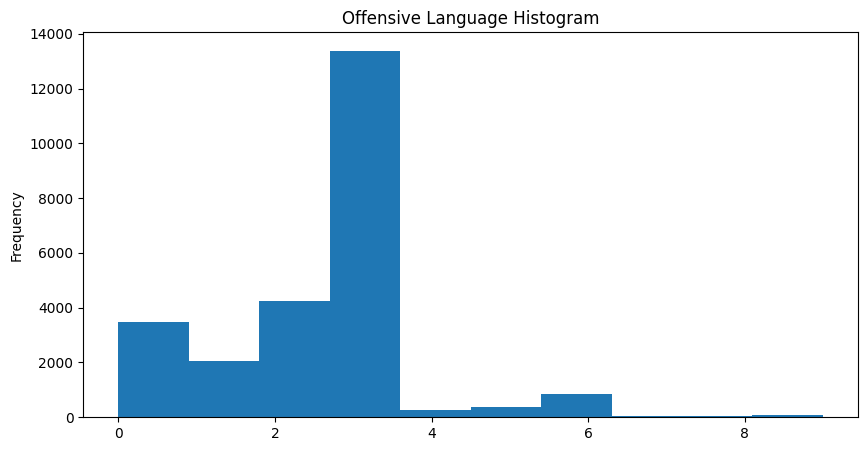

In [17]:
data['offensive_language'].plot.hist(title='Offensive Language Histogram',bins=10,figsize=(10,5))

#### 3.5. Neither:

* *Number of CrowdFlower users who judged the tweet to be neither offensive nor non-offensive.*

In [18]:
data['neither'].value_counts()

neither
0    18892
3     2790
1     1694
2     1200
6      103
5       54
4       35
9        5
8        5
7        5
Name: count, dtype: int64

<Axes: title={'center': 'Neither Histogram'}, ylabel='Frequency'>

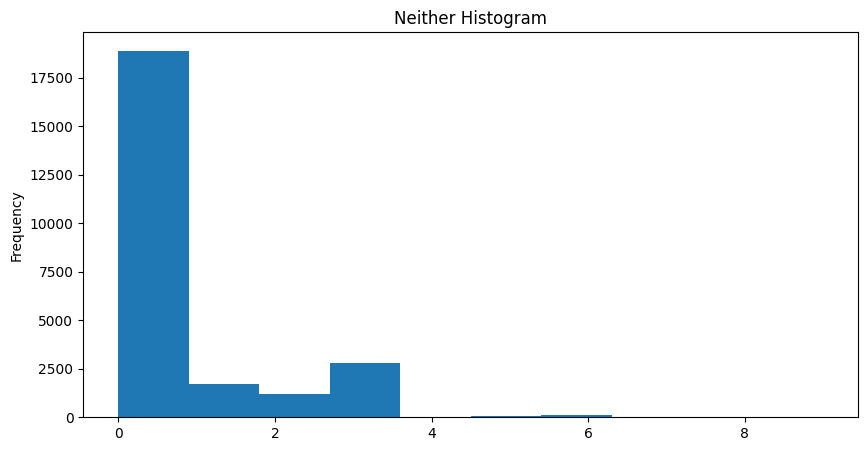

In [19]:
data['neither'].plot.hist(title='Neither Histogram',bins=10,figsize=(10,5))

### 4. Data Preproccessing

In [20]:
tweets = data[['tweet']]
tweets

,tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,"you've gone and broke the wrong heart baby, an..."
24780,young buck wanna eat!!.. dat nigguh like I ain...
24781,youu got wild bitches tellin you lies


* *As we saw the tweet column has data need to be cleaned and preprocess to be ready for traning the model.*
*in this cell the clean function will make series of preprocessing steps is designed to clean the text data by removing URLs, HTML tags, punctuation, newline characters, and words containing digits, while also converting the text to lowercase for consistency in processing.*

* *In additional to cleaning text it needs two more preprocessing steps :*

* *  *removing stop words which are occur frequently and do not carry much meaning on their own* <br>
* *  *transforming words into their base or root forms ex: "playing" becomes "play"*

In [23]:
wordnet = WordNetLemmatizer()

In [26]:
def clean(text):
  text = str(text).lower()
  text = re.sub('[.?]', '', text)  # Remove punctuation (periods and question marks)
  text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
  text = re.sub('<.?>+', '', text)  # Remove HTML tags
  text = re.sub(r"[^\w\s]", '', text)  # Remove non-alphanumeric and non-whitespace characters
  text = re.sub('\n', '', text)  # Remove newline characters
  text = re.sub(r'\w\d\w', '', text)  # Optional removal of words with digit in middle
  text = [wordnet.lemmatize(word) for word in text.split(' ') if word not in stop_words]
  text = " ".join(text)
  return text

In [27]:
data["tweet"] = data['tweet'].apply(clean)

In [28]:
data.head()

,INDEX,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely woman shouldnt complain clean...
1,1,3,0,3,0,1,rt mlee boy dat coldtyga dwn bad cuffin dat h...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt babife ever fuck bit...
3,3,3,0,2,1,1,rt c_g_anderson viva_based look like tranny
4,4,6,0,6,0,1,rt shenikaroberts shit hear might true might ...


In [29]:
categories = {0:"hate Speech",1:"Offensive speech",2:"Neither"}
value = data['class'].map(categories)

In [30]:
index = data.columns.get_loc("tweet")
data.insert(index,'value',value)

In [31]:
data.head(10)

,INDEX,count,hate_speech,offensive_language,neither,class,value,tweet
0,0,3,0,0,3,2,Neither,rt mayasolovely woman shouldnt complain clean...
1,1,3,0,3,0,1,Offensive speech,rt mlee boy dat coldtyga dwn bad cuffin dat h...
2,2,3,0,3,0,1,Offensive speech,rt urkindofbrand dawg rt babife ever fuck bit...
3,3,3,0,2,1,1,Offensive speech,rt c_g_anderson viva_based look like tranny
4,4,6,0,6,0,1,Offensive speech,rt shenikaroberts shit hear might true might ...
5,5,3,1,2,0,1,Offensive speech,t_madison_x shit blow meclaim faithful somebod...
6,6,3,0,3,0,1,Offensive speech,__brighterdays sit hate another bitch got muc...
7,7,3,0,3,0,1,Offensive speech,0selfiequeenbri cause im tired big bitch comin...
8,8,3,0,3,0,1,Offensive speech,amp might get ya bitch back amp thats
9,9,3,1,2,0,1,Offensive speech,rhythmixx_ hobby include fighting mariambitch


### 5. Spliting Data:

In [32]:
X = np.array(data['tweet'])
y = np.array(data['class'])

cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### 6. Model Training

In [33]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 7. Model Testing

In [34]:
y_val_prediction = clf.predict(X_val)
score = accuracy_score(y_val, y_val_prediction)
print("Validation Score: {:.4f}".format(score))

Validation Score: 0.8689


In [35]:
y_test_prediction = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_prediction)
print("Test Accuracy: {:.4f}".format(test_accuracy))

Test Accuracy: 0.8654


### 8. Logistic Regrission

In [36]:
lr = LogisticRegression(max_iter= 100)
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(lr_prediction, y_test)

In [37]:
print("Test Accuracy: {:.2f}%".format(lr_accuracy*100))

Test Accuracy: 89.31%


### 9. Prediction Phase:

In [38]:
i = ""
i = cv.transform([i]).toarray()
print(clf.predict((i)))

[2]


In [39]:
import speech_recognition as sr
r = sr.Recognizer()
with sr.AudioFile('harvard.wav') as source:
    audio = r.listen(source)
    try:
        text = r.recognize_google(audio)
        print("You said: {}".format(text))
    except sr.UnknownValueError:
        print("Sorry could not understand audio")
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))

text =  cv.transform([text]).toarray()
print(clf.predict((text)))

You said: the still smell of old buildings it takes heat to bring out the order a cold exhaust a sole please find with him tacos Alpha store are my favourite is just for food is the hard cross bun
[2]
